In [1]:
# Importar librerías necesarias
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import payments_manager as pm
import numpy as np

#pm.help()
pm.init(debug=True)
pm.info()
df_jo = pm.df('df_jo')
df_jo.info()
pm.info()

Lista de dataframes: ['cr', 'fe', 'cr_cp', 'fe_cp', 'df_jo', 'df_jall']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32094 entries, 0 to 32093
Data columns (total 31 columns):
 #   Column                      Non-Null Count  Dtype          
---  ------                      --------------  -----          
 0   id_cr                       32094 non-null  int64          
 1   amount                      32094 non-null  float64        
 2   stat_cr                     32094 non-null  object         
 3   created_at                  32094 non-null  datetime64[ns] 
 4   user_id                     32094 non-null  int64          
 5   active                      32094 non-null  int64          
 6   moderated_at                21759 non-null  datetime64[ns] 
 7   reimbursement_date          32094 non-null  datetime64[ns] 
 8   cash_request_received_date  24149 non-null  datetime64[ns] 
 9   money_back_date             23917 non-null  datetime64[ns] 
 10  transfer_type               32094 

In [2]:
# Crear columna 'Cohorte' que indica el mes de la primera solicitud de cada cliente
df_jo['Cohorte'] = df_jo.groupby('user_id')['created_at'].transform('min').dt.to_period('M')
df_jo.head(10)

,id_cr,amount,stat_cr,created_at,user_id,active,moderated_at,reimbursement_date,cash_request_received_date,money_back_date,...,stat_fe,category,fee,paid_at,from_date,to_date,charge_moment,cr_received_date,to_reimbur_cash_de,Cohorte
0,5,100.0,rejected,2019-12-10 19:05:21.596873,804,1,2019-12-11 16:47:42.405646,2020-01-09 19:05:21.596363,NaT,NaT,...,NaN,NaN,NaN,NaT,NaT,NaT,NaN,NaT,NaN,2019-12
1,70,100.0,rejected,2019-12-10 19:50:12.347780,231,1,2019-12-11 14:24:22.897988,2020-01-09 19:50:12.347780,NaT,NaT,...,NaN,NaN,NaN,NaT,NaT,NaT,NaN,NaT,NaN,2019-12
2,7,100.0,rejected,2019-12-10 19:13:35.825460,191,1,2019-12-11 09:46:59.777728,2020-01-09 19:13:35.825041,NaT,NaT,...,NaN,NaN,NaN,NaT,NaT,NaT,NaN,NaT,NaN,2019-12
3,10,99.0,rejected,2019-12-10 19:16:10.880172,761,1,2019-12-18 14:26:18.128407,2020-01-09 19:16:10.879606,NaT,NaT,...,NaN,NaN,NaN,NaT,NaT,NaT,NaN,NaT,NaN,2019-12
4,1594,100.0,rejected,2020-05-06 09:59:38.877376,7686,1,2020-05-07 09:21:55.320193,2020-06-05 22:00:00.000000,NaT,NaT,...,NaN,NaN,NaN,NaT,NaT,NaT,NaN,NaT,NaN,2020-05
5,2145,100.0,money_back,2020-05-23 20:58:55.129432,9489,1,2020-05-24 12:40:33.054910,2020-06-06 22:00:00.000000,2020-05-26,2020-07-06 03:36:03.023521,...,NaN,NaN,NaN,NaT,NaT,NaT,NaN,2020-05-26,NaN,2020-05
6,3512,100.0,rejected,2020-06-16 17:07:38.452652,14631,1,2020-06-17 10:21:21.360742,2020-07-11 23:51:00.000000,NaT,NaT,...,NaN,NaN,NaN,NaT,NaT,NaT,NaN,NaT,NaN,2020-06
7,654,100.0,rejected,2020-02-10 01:11:53.808270,99000309,0,2020-02-10 09:11:21.350695,2020-03-11 01:11:53.807930,NaT,NaT,...,NaN,NaN,NaN,NaT,NaT,NaT,NaN,NaT,NaN,2020-01
8,5672,100.0,canceled,2020-06-28 12:06:33.712840,99002499,0,NaT,2020-07-07 22:00:00.000000,NaT,NaT,...,NaN,NaN,NaN,NaT,NaT,NaT,NaN,NaT,NaN,2020-06
9,71,90.0,rejected,2019-12-10 19:51:23.911206,897,1,2019-12-12 15:06:11.190299,2019-12-17 19:51:23.910748,NaT,NaT,...,NaN,NaN,NaN,NaT,NaT,NaT,NaN,NaT,NaN,2019-12


In [3]:
cohort_analysis_2 = (
    df_jo.groupby(['user_id', 'Mes_created_at'], as_index=False)
    .agg(
        # Sumar los valores de 'fee' donde 'stat_fe' es igual a 'accepted'
        total_paid_fees=('fee', lambda x: x[df_jo.loc[x.index, 'stat_fe'] == 'accepted'].sum()),
        
        # Sumar los valores de 'amount' donde 'stat_cr' es igual a 'money_back'
        total_paid_cr=('amount', lambda x: x[df_jo.loc[x.index, 'stat_cr'] == 'money_back'].sum()),

        # Calcular la media de 'to_reimbur_cash'
        reimburse_lapse=('to_reimbur_cash', 'mean'),

        # Contar los valores únicos de 'id_cr' donde 'stat_cr' es igual a 'money_back'
        Num_Solicitudes=('id_cr', lambda x: x[df_jo.loc[x.index, 'stat_cr'] == 'money_back'].nunique())
    )
)

# Restablecer el índice para un DataFrame limpio (opcional, ya garantizado por as_index=False)
cohort_analysis_2.reset_index(drop=True, inplace=True)

# Calcular el índice como porcentaje entre 'total_paid_fees' y 'total_paid_cr'
cohort_analysis_2['index'] = (
    cohort_analysis_2['total_paid_fees'] / cohort_analysis_2['total_paid_cr']
) * 100

# Reemplazar valores 'inf' con 0 para manejar divisiones por cero
cohort_analysis_2['index'] = cohort_analysis_2['index'].replace(np.inf, 0)

# Calcular la fecha del último pedido por usuario a partir del DataFrame original
df_jo['created_at'] = pd.to_datetime(df_jo['created_at'])  # Asegurarse de que el formato sea datetime
last_order_per_user = (
    df_jo.groupby('user_id')['created_at']
    .max()  # Obtener la fecha más reciente de pedido para cada usuario
    .dt.to_period('M')  # Convertir a periodo mensual
    .reset_index()  # Restablecer el índice para facilitar el merge
)

# Incorporar la fecha del último pedido en el DataFrame de análisis de cohortes
cohort_analysis_2 = pd.merge(
    cohort_analysis_2,
    last_order_per_user.rename(columns={'created_at': 'last_order'}),
    on='user_id',
    how='left'
)

# Resultado final del DataFrame de análisis de cohortes
cohort_analysis_2


,user_id,Mes_created_at,total_paid_fees,total_paid_cr,reimburse_lapse,Num_Solicitudes,index,last_order
0,34,2020-04,0.0,0.0,NaT,0,NaN,2020-04
1,35,2019-12,0.0,0.0,NaT,0,NaN,2020-09
2,35,2020-01,0.0,0.0,NaT,0,NaN,2020-09
3,35,2020-02,0.0,0.0,NaT,0,NaN,2020-09
4,35,2020-03,0.0,0.0,NaT,0,NaN,2020-09
...,...,...,...,...,...,...,...,...
20469,99030337,2020-07,10.0,300.0,NaT,1,3.333333,2020-10
20470,99030337,2020-10,5.0,100.0,24 days 20:48:28.229975,1,5.000000,2020-10
20471,99030367,2020-10,5.0,100.0,7 days 07:18:02.098054,1,5.000000,2020-10
20472,99030404,2020-10,5.0,100.0,19 days 01:50:14.537587,1,5.000000,2020-10


In [27]:
# Ordenar por el número de solicitudes, el monto total de tarifas pagadas, el tiempo de reembolso, y el índice, en orden ascendente excepto para el índice
sort_cohort_amount_2020_03 = cohort_analysis_2.sort_values(by=['Num_Solicitudes', 'total_paid_fees', 'reimburse_lapse', 'index'], ascending=[False, False, False, True])

morosos_cr= sort_cohort_amount_2020_03[sort_cohort_amount_2020_03['total_paid_cr']==0]
morosos_cr_id_unicos=morosos_cr['user_id'].unique()
print(len(morosos_cr_id_unicos))

cancelados_morosos_cr = morosos_cr_id_unicos[morosos_cr_id_unicos > 200000]
len(cancelados_morosos)


3646


830

In [28]:
morosos_fe=sort_cohort_amount_2020_03[sort_cohort_amount_2020_03['total_paid_fees']==0]
morosos_fe_id_unico=morosos_fe['user_id'].unique()
print(len(morosos_fe_id_unico))

cancelados_morosos_fe=morosos_fe_id_unico[morosos_fe_id_unico>200000]
len(cancelados_morosos_fe)

5673


971

In [31]:
#Ordenar el cohort_analysis_2 para buscar los peores clientes que son los morosos para el amount y para el fee.
cohort_morosos=(
    df_jo.groupby(['user_id', 'Mes_created_at'], as_index=False)
    .agg(
        # Sumar los valores de 'fee' donde 'stat_fe' es igual a 'rejected' por lo que no las hemos podido cobrar
        total_debt_fees=('fee', lambda x: x[df_jo.loc[x.index, 'stat_fe'] == 'rejected'].sum()),
        
        # Sumar los valores de 'amount' donde 'stat_cr' es igual a 'direct_debit_rejected'
        total_debt_cr=('amount', lambda x: x[df_jo.loc[x.index, 'stat_cr'] == 'direct_debit_rejected'].sum()),

        # Calcular los días que lleva de morosidad con 'to_reimbur_cash'
        reimburse_lapse=('to_reimbur_cash_de', lambda x:x[df_jo.loc[x.index, 'to_reimbur_cash_de']<0].sum()),

        # Contar los valores únicos de 'id_cr' donde 'stat_cr' es igual a 'direct_debit_rejected'
        Num_Solicitudes=('id_cr', lambda x: x[df_jo.loc[x.index, 'stat_cr'] == 'direct_debit_rejected'].nunique())
    )
)

cohort_morosos

,user_id,Mes_created_at,total_debt_fees,total_debt_cr,reimburse_lapse,Num_Solicitudes
0,34,2020-04,0.0,0.0,0.0,0
1,35,2019-12,0.0,0.0,0.0,0
2,35,2020-01,0.0,0.0,0.0,0
3,35,2020-02,0.0,0.0,0.0,0
4,35,2020-03,0.0,0.0,0.0,0
...,...,...,...,...,...,...
20469,99030337,2020-07,0.0,0.0,0.0,0
20470,99030337,2020-10,0.0,0.0,0.0,0
20471,99030367,2020-10,0.0,0.0,0.0,0
20472,99030404,2020-10,0.0,0.0,0.0,0


In [34]:
# Iterar por todas las columnas del DataFrame y mostrar sus valores únicos
for columna in cohort_morosos.columns:
    valores_unicos = cohort_morosos[columna].unique()
    print(f"Columna: {columna}")
    print(valores_unicos)
    print("-" * 50)  # Separador para claridad

Columna: user_id
[      34       35       47 ... 99030367 99030404 99030445]
--------------------------------------------------
Columna: Mes_created_at
<PeriodArray>
['2020-04', '2019-12', '2020-01', '2020-02', '2020-03', '2020-08', '2020-09',
 '2019-11', '2020-05', '2020-10', '2020-06', '2020-07', '2020-11']
Length: 13, dtype: period[M]
--------------------------------------------------
Columna: total_debt_fees
[ 0.  5. 10. 15. 20.]
--------------------------------------------------
Columna: total_debt_cr
[   0.  100.   10.  200.   50.   99.   80.  500.  150.  400.  600.  900.
  300.  240.  800.   25.  180.  700.  350.  250.  140. 1000.   20.   75.
   60.   30.   40.  160.  450. 1100. 1400.  750.  320.]
--------------------------------------------------
Columna: reimburse_lapse
[ 0. -2. -1. -3. -4. -6.]
--------------------------------------------------
Columna: Num_Solicitudes
[0 1 2]
--------------------------------------------------


In [41]:
# Pivotar los datos para las métricas relevantes
heatmap_fees = cohort_morosos.pivot(index='user_id', columns='Mes_created_at', values='total_debt_fees')
heatmap_cr = cohort_morosos.pivot(index='user_id', columns='Mes_created_at', values='total_debt_cr')
heatmap_lapse = cohort_morosos.pivot(index='user_id', columns='Mes_created_at', values='reimburse_lapse')

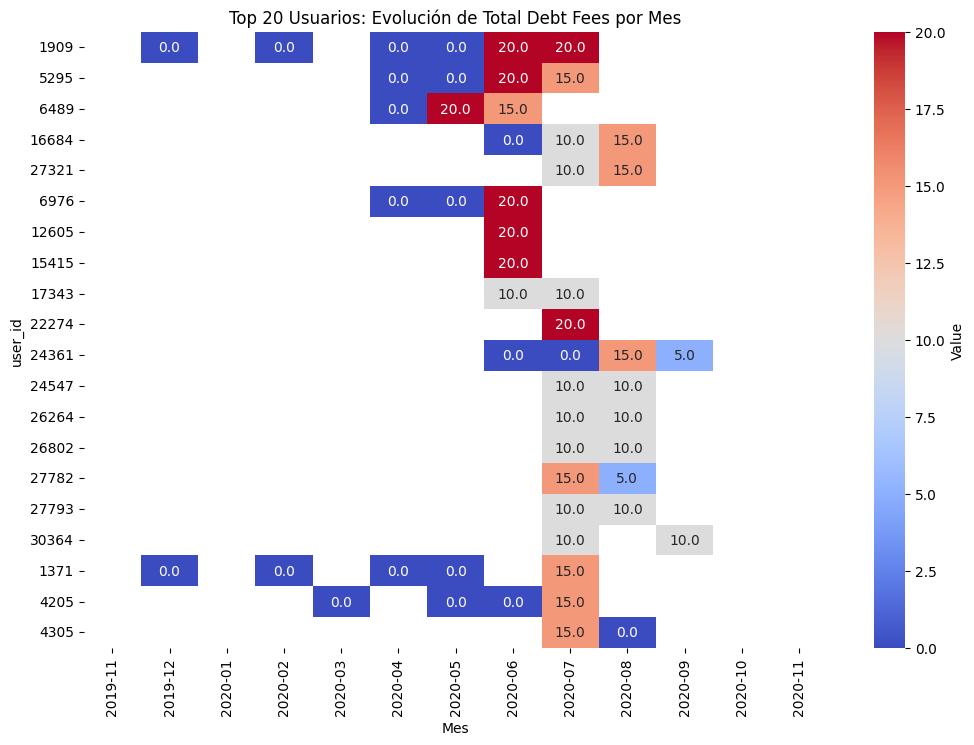

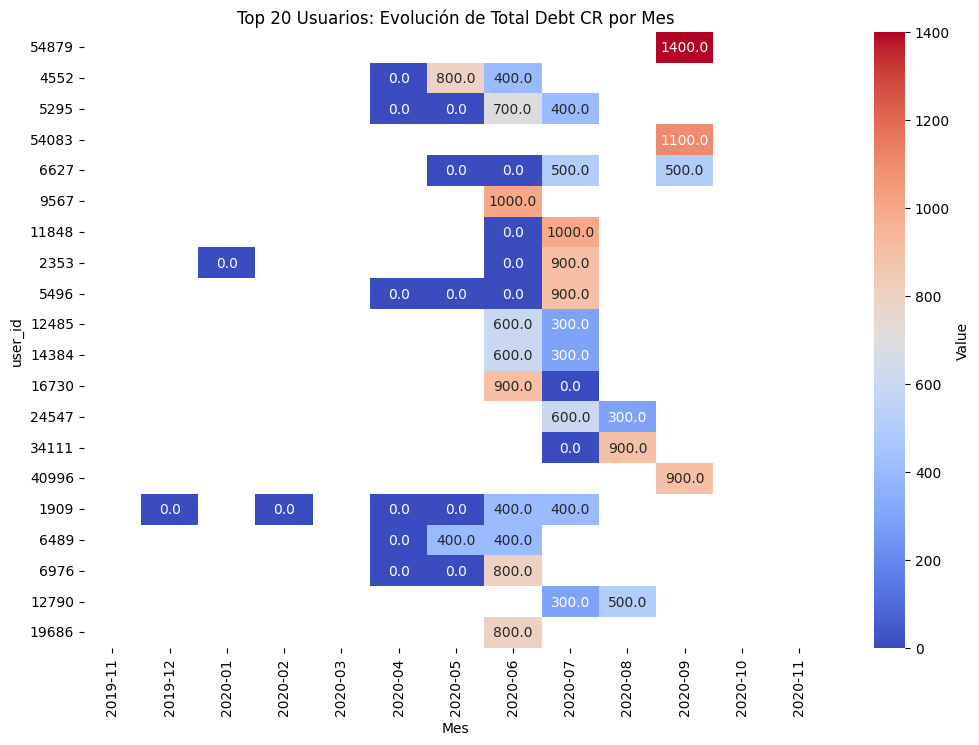

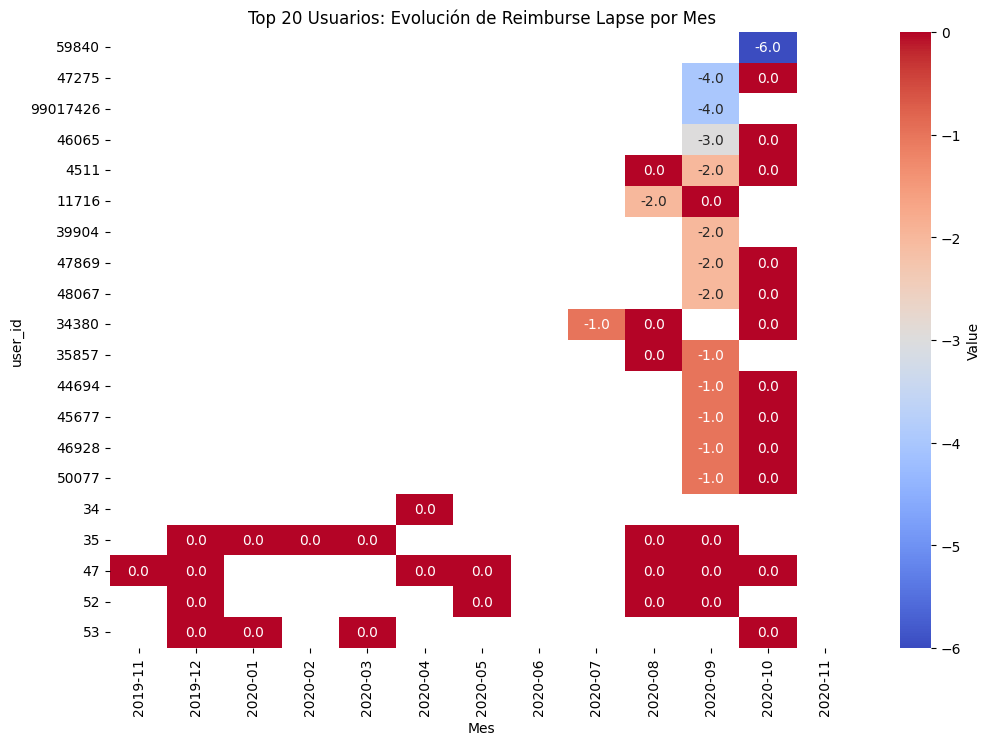

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt


# Seleccionar los top 20 usuarios para cada métrica
top_users_fees = heatmap_fees.sum(axis=1).nlargest(20).index  # Total Debt Fees
top_users_cr = heatmap_cr.sum(axis=1).nlargest(20).index      # Total Debt CR
top_users_lapse = heatmap_lapse.sum(axis=1).nsmallest(20).index  # Reimburse Lapse (valores más negativos)

# Filtrar los datos para los top 20 usuarios
heatmap_fees_top = heatmap_fees.loc[top_users_fees]
heatmap_cr_top = heatmap_cr.loc[top_users_cr]
heatmap_lapse_top = heatmap_lapse.loc[top_users_lapse]

# Función para graficar heatmaps
def plot_heatmap(data, title, cmap="coolwarm"):
    plt.figure(figsize=(12, 8))
    sns.heatmap(data, annot=True, fmt=".1f", cmap=cmap, cbar_kws={'label': 'Value'})
    plt.title(title)
    plt.xlabel('Mes')
    plt.ylabel('user_id')
    plt.show()

# Graficar los heatmaps para los top usuarios de cada métrica
plot_heatmap(heatmap_fees_top, "Top 20 Usuarios: Evolución de Total Debt Fees por Mes")
plot_heatmap(heatmap_cr_top, "Top 20 Usuarios: Evolución de Total Debt CR por Mes")
plot_heatmap(heatmap_lapse_top, "Top 20 Usuarios: Evolución de Reimburse Lapse por Mes")


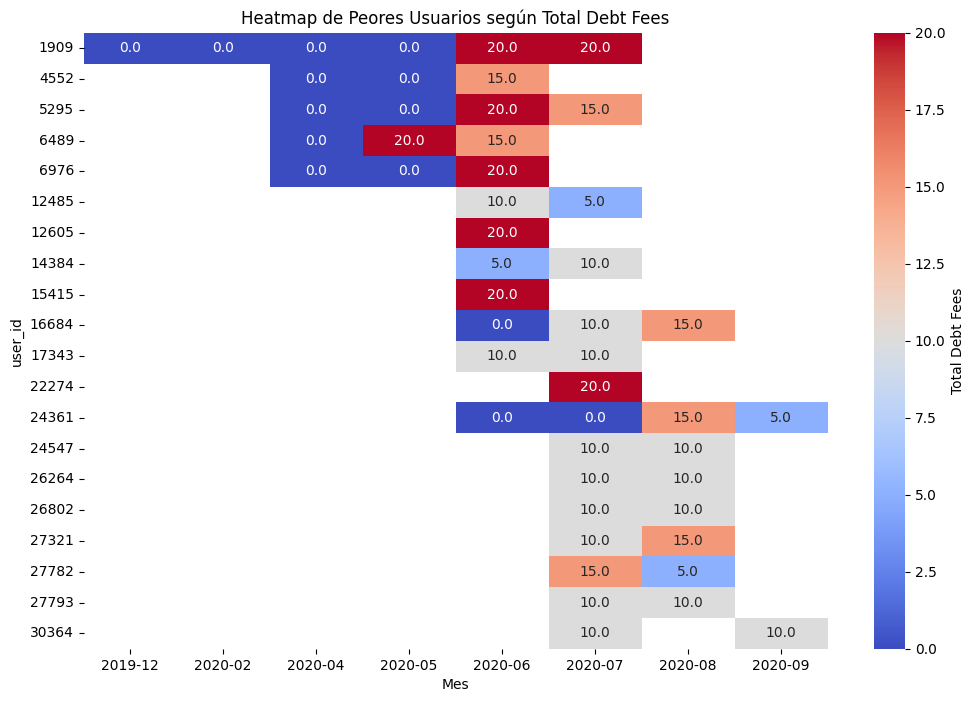

In [44]:
# 1. Filtrar los usuarios con las tres métricas ordenadas
worst_users = (
    cohort_morosos
    .groupby('user_id')
    .agg(
        total_debt_fees_sum=('total_debt_fees', 'sum'),
        total_debt_cr_sum=('total_debt_cr', 'sum'),
        reimburse_lapse_min=('reimburse_lapse', 'min')  # Más negativo
    )
    .sort_values(
        by=['total_debt_fees_sum', 'total_debt_cr_sum', 'reimburse_lapse_min'], 
        ascending=[False, False, True]  # Fees y CR descendente, lapse ascendente (más negativo)
    )
    .head(20)  # Seleccionar los top 20 peores usuarios
    .index
)

# 2. Filtrar el DataFrame original para incluir solo los usuarios seleccionados
cohort_morosos_worst = cohort_morosos[cohort_morosos['user_id'].isin(worst_users)]

# 3. Pivotar para crear una tabla por usuario y mes
heatmap_data_combined = cohort_morosos_worst.pivot(index='user_id', columns='Mes_created_at', values='total_debt_fees')

# 4. Graficar el heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data_combined, annot=True, fmt=".1f", cmap="coolwarm", cbar_kws={'label': 'Total Debt Fees'})
plt.title('Heatmap de Peores Usuarios según Total Debt Fees')
plt.xlabel('Mes')
plt.ylabel('user_id')
plt.show()

In [5]:
# Pivot to show months as columns
cohort_amount_top20 = top_20_users.pivot(index='user_id', columns='Mes_created_at', values='index')

# Display the result
cohort_amount_top20

Mes_created_at,2020-06,2020-08,2020-09,2020-10
user_id,,,,
526,NaN,NaN,NaN,5.357143
1127,NaN,13.636364,NaN,NaN
10606,NaN,NaN,5.000000,NaN
10614,5.000000,NaN,NaN,NaN
12274,7.142857,NaN,NaN,NaN
12934,NaN,NaN,11.764706,50.000000
13964,NaN,5.000000,NaN,5.000000
18148,NaN,NaN,4.166667,NaN
18744,NaN,4.000000,NaN,NaN


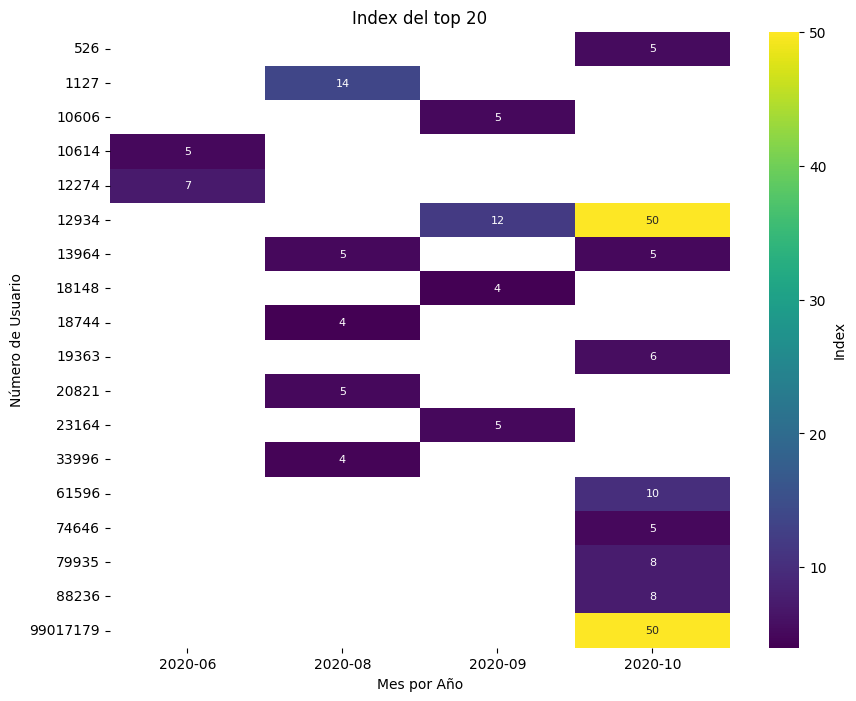

In [6]:
# Graficar la cantidad de adelanto de efectivo de un cohorte por meses y número de usuarios
plt.figure(figsize=(10, 8))
plt.title('Index del top 20')
sns.heatmap(data=cohort_amount_top20, annot=True, fmt='.0f', cmap='viridis', annot_kws={"size": 8}, cbar_kws={'label': 'Index'})
plt.xlabel('Mes por Año')
plt.ylabel('Número de Usuario')
plt.show()